<a href="https://colab.research.google.com/github/Shakilkhan24/Playground_DL/blob/main/lora_adapter_with_transformers_HF_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install peft



```
# peft - parameter efficient fine tuning
# lora and more

# after adding adapter, we can enable or disable in any time
# also initialize random weights for the adapter
```

In [2]:
from transformers import AutoModelForCausalLM, OPTForCausalLM, AutoTokenizer

from peft import PeftConfig

model_id = "facebook/opt-350m"
adapter_model_id = "ybelkada/opt-350m-lora"
tokenizer = AutoTokenizer.from_pretrained(model_id)
text = "Hello"
inputs = tokenizer(text, return_tensors="pt")

model = AutoModelForCausalLM.from_pretrained(model_id)

peft_config = PeftConfig.from_pretrained(adapter_model_id)

# to initiate with random weights
peft_config.init_lora_weights = False

model.add_adapter(peft_config)
model.enable_adapters()
output = model.generate(**inputs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/416 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(




```
# Explore Lora
```



In [3]:
print(model)    # lora architecture from one of HuggingFace implementation on lora

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 512, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
      (project_out): Linear(in_features=1024, out_features=512, bias=False)
      (project_in): Linear(in_features=512, out_features=1024, bias=False)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): lora.Linear(
              (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
              (lora_dropout): ModuleDict(
                (default): Dropout(p=0.05, inplace=False)
              )
              (lora_A): ModuleDict(
                (default): Linear(in_features=1024, out_features=16, bias=False)
              )
              (lora_B): ModuleDict(
                (default): Linear(in_features=16, out_features=1024, bias=Fa

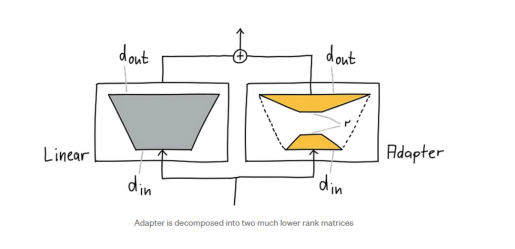

In [13]:
import matplotlib.pyplot as plt
image_path = "path_to_your_image.jpg"
image = plt.imread('/content/Low_rank_adapter.PNG')
plt.imshow(image)
plt.axis('off')
plt.show()



```
left side is 'base' layer

----- right side is A to B ----- (adapter)
infeatures to 16 -> 16 to out_features  
```



# Rough implementation




In [10]:
import torch
import torch.nn as nn
class LORADropout(nn.Module):
    def __init__(self, p=0.05):
        super(LORADropout, self).__init__()
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        return self.dropout(x)


class LORALinear(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super(LORALinear, self).__init__()
        self.base_layer = nn.Linear(in_features, out_features, bias=bias)

        self.lora_dropout = nn.ModuleDict({'default': LORADropout()})
        self.lora_A = nn.ModuleDict({'default': nn.Linear(in_features, 16, bias=False)})
        self.lora_B = nn.ModuleDict({'default': nn.Linear(16, out_features, bias=False)})
        self.lora_embedding_A = nn.ParameterDict()
        self.lora_embedding_B = nn.ParameterDict()

    def forward(self, x):
        lora_drop = self.lora_dropout['default'](x)
        lora_A = self.lora_A['default'](x)
        lora_B = self.lora_B['default'](lora_A)
        lora_embedding_A = self.lora_embedding_A.get('default')
        lora_embedding_B = self.lora_embedding_B.get('default')

        if lora_embedding_A is not None:
            lora_A = lora_A + lora_embedding_A
        if lora_embedding_B is not None:
            lora_B = lora_B + lora_embedding_B

        lora_output = self.base_layer(x) + lora_drop * lora_B
        return lora_output



```
from peft import LoraConfig
# now we can config the adapter in diff. ways
```



In [4]:
# Diff. configurations
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

In [8]:
print(peft_config)

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=64, target_modules=None, lora_alpha=16, lora_dropout=0.1, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})
